# Simulation of a positron-induced Muon Source (part 1)

### Description

The production of a high brillance muon beam is one of the most important challenge for the future of Particle Physics. A particularly interesting idea consists of shooting high energy positrons on a target, aiming at the production of muons by means of the process $e^+ + e^- \rightarrow \mu^+ + \mu^-$. To mimize the divergence of the resulting "muon beam", the positrons energy is chosen so that the reaction occurs close to threshold (assuming the electrons in the target to be at rest). The main goal of this project is to produce a Monte Carlo simulation of such a process. 

### Assignments

The project is split into two parts, which are both reported here for consistency. This group has only to cover _part 1_.

#### Part 1: generate a simulated dataset of $e^+ + e^- \rightarrow \mu^+ + \mu^-$ events.

1. Compute the process leading-order cross section, $\sigma(\theta; \sqrt{s})$, as a function of the scattering angle $\theta$ and with the  center of mass energy $\sqrt{s}$ as a parameter. Start by computing it in the center of mass system. N.B.: textbooks reports such cross section in the relativistic limit, i.e. for $\sqrt{s}\gg m_\mu$, which is clearly not the case here ($\sqrt{s}\sim 2m_\mu$);
2. compute and display the angle and momentum components distributions of the emerging muon pairs;
3. boost muons four-momenta in the laboratory frame, i.e. in the frame where the electron is at rest and the positron has enough energy to give rise to the process;
4. write a Monte Carlo simulation that generates scattering events following the distributions that you found analytically; 
5. produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be listed as rows in a file with columns representing the muons coordinates (keep in mind that in the lab frame muons are relativistic and thus the number of coordinates can be only 3 per muon);
6. assume a $3$ cm thick Beryllium block is used as target and a rate of positron on target of $10^6$ Hz. Compute the rescaling factor (weight) you need to apply to the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations;
7. repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV;
8. given that the electrons traversing the target lose energy as $E(z)=E_0 \exp{-z/X_0}$ (with z the longitudinal coordinate of the target, the one parallel to the beam direction and $X_0$ (35.28 cm, Dudo) is the Beryllium radiation length), compute the nominal beam energy $E_0$ such that muon pairs can be generated along the whole length of the target;
9. (optional) take the former point into account when generating the events (i.e. the proccess $\sqrt{s}$ depend on the position along the target where the $e^+ - e^-$ scattering occurrs.

### Simulation of positron-induced Muon Source

The main goal of this project is the simulation of a muon source induced by an electron-positron pair annihilation.

The calculation of the cross section comes from the derivation of the unpolarised scattering amplitude - we are not interested in the polarisation of both incoming and outgoing particles. 
Moreover, we are not interested in considering the annihilation in the usual Ultra Relativistic limit ($m \sim 0$), but we are interested in the range of energy close to the threshold for the muon pair production: $\sqrt s \sim 2m_\mu$. 

1. The differential cross section for the considered process, in the CoM frame (\*-quantities), has the following expression: $$\left(\frac{d\sigma}{d\Omega}\right)^* \Big\rvert_{CoM} (\sqrt s, \theta^*, \phi^*)= \frac{\alpha^2}{4s}\left(1-\frac{4m_\mu^2}{s}\right)^{1/2}\left(1-\frac{4m_e^2}{s}\right)^{-1/2}\left[1+\frac{4}{s}\left(m_e^2+m_\mu^2\right)+\left(1-\frac{4m_\mu^2}{s}\right)\left(1-\frac{4m_e^2}{s}\right)\cos^2\theta^*\right]$$

where the differential cross section in the center of mass is expressed as a function of the (CoM) energy $\sqrt s$ (the first Mandelstam variable, equal for both $e$ and $\mu$ pairs in che CoM frame), the masses of $e^+$ and $e^-$ $m_e$ and of the muons $m_\mu$, and the emission angle in the center of mass $\theta^*$. ($\alpha$ is the EM constant, $\alpha=\frac{e^2}{4\pi}$). One can also notice that the differential cross section depends only on the $\theta^*$ angle, and not on the other angle $\phi^*$.

The total cross section can be found by integrating over the solid angle. 
$$ \sigma (\sqrt s) = \int_{4\pi} d \Omega^* \frac{d\sigma^*}{d\Omega^*} = \int_0^{\pi} d\theta^* sin\theta^* \int_0^{2\pi} d\phi^* \frac{d\sigma^*}{d\Omega^*} =  4\pi\frac{\alpha^2}{3s^3}\left(1-\frac{4m_\mu^2}{s}\right)^{1/2}\left(1-\frac{4m_e^2}{s}\right)^{-1/2}(2m_e^2+s)(2m_\mu^2+s) $$ 
 
2. The angular distribution can be simply computed normalizing the differential cross section with respect to the total one: 
$$ f(\theta^*, \phi^*) = \frac{1}{\sigma} \frac{d\sigma^*}{d\Omega^*}$$ 

In order to get the distribution of just the $\theta^*$ angle we integrate over $\phi^*$, and we consider the module of the determinant of the jacobian of the trasformation from cartesian coordinates to spherical coordinates $$\frac{\partial(x,y,z)}{\partial(\theta^*,\phi^*)}=sin(\theta^*)$$ getting 
$$ pf(\theta^*) = \frac{1}{\sigma} \frac{d\sigma^*}{d\Omega^*}\times 2\pi\times sin(\theta^*)$$ 

As we are considering a case in which we have a stationary target, we need to pass from the CoM coordinates to the LAB ones. Of course a Lorentz boost is going to be involved for both angles and spatial coordinates. 

In the CoM frame, the 4-momentum for the incoming and outgoing particles can be written as: 
$$p_{e^\pm}^* = (E^*, \pm \vec p_e^{\,*}) \,\,\,\,\,\,\, p_{\mu ^\pm}^{\prime\,*} = (E^*, \pm \vec p_\mu^{\,\prime\,*})$$

The speed of the center of mass $\beta^*$, in the case in which we consider the electron at rest, is given by: 
        $$ \beta^* = \frac{p_{e^+}}{E_{e^+}+m_{e^-}}$$
Moreover, as we consider a process in which two muons are produced ($m_\mu \sim 207 m_e$), we can well approximate the parameter $ \beta^* \sim \frac{p_{e^+}}{E_{e^+}} = \beta_{e^+} $ (The energy of the incoming positron needs to be over a certain threshold to produce the muon pair ( $\sim 45 \, GeV$ )

The energy of the CoM $E^*$ can be written in terms of the Mandelstam variable *s*: $\sqrt s = \sqrt{p_{e^-}^2+p_{e^+}^2} = 2E^*$ ( $\sim 2m_\mu$ in the considered case).

And so, it follows:

$$\beta^*_{e^\pm} = \frac{\lvert\vec p^{\,*}\rvert}{E^*} = \frac{ \sqrt{(E^*)^2-m_e^2}}{E^*} = \sqrt{1-\frac{4m_e^2}{s} } $$

And analogously, $$\beta^*_{\mu^\pm} = \sqrt{1-\frac{4m_\mu^2}{s}}$$
(These two factors also appear in the cross section formula).

## Computing and displaying the angle and momentum components distributions of the emerging muon pairs;

At first, we define physical constants and import libraries

In [36]:
#import cell
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as clr
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d



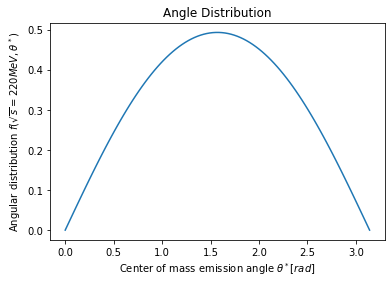

It can be also verified that this distribution is well reproduced at different values of s.


In [2]:
alpha  = 1/(137.035999084) #dimensionless CODATA 2018 Fine-Structure constant
m_muon = 105.6583755       #[MeV] CODATA 2018 Muon mass
m_e    = 0.51099895        #[MeV] CODATA 2018 Electron mass
s      = 220**2            #[MeV] For the sake of simplicity we take as a reference pow(sqrt(s),2). 
                           #We have choosen a s-value close to 2 m_mu, as required by the considered process
#differential cross section
def dsigmadtheta(s,theta, phi = 0):
    return (alpha**2/(4*s))*(1-(4*m_muon**2)/s)**0.5*((1-(4*m_e**2)/s))**-0.5*(1+(4/s)*(m_e**2+m_muon**2)+(1-(4*m_e**2)/s)*(1-(4*m_muon**2)/s)*np.cos(theta)**2)

#total cross section
def sigma(s):
    return 4*np.pi*(alpha**2/(3*s**3))*(1-(4*m_muon**2)/s)**0.5*((1-(4*m_e**2)/s))**-0.5*(2*m_e**2+s)*(2*m_muon**2+s)

#theta probability distribution
def pf(s,theta, phi = 0):
    return dsigmadtheta(s,theta)/sigma(s)*2*np.pi*np.sin(theta)

#plotting pf
x = np.linspace(0,np.pi,100)
plt.title("Angle Distribution")
plt.xlabel(r'Center of mass emission angle $\theta^*[rad]$' )
plt.ylabel(r'Angular distribution $f(\sqrt{s} = 220 MeV, \theta^*)$' )

plt.plot(x, pf(s,x))
plt.show()

print("It can be also verified that this distribution is well reproduced at different values of s.")

### Computing the cumulative function $g(\theta^*$)
In order to write the actual components of the momentum of the emitted muons, we need to generate some random numbers distributed accordingly to the angle distribution just shown.

In order to achieve such a result, we need to calculate the cumulative density funcion (CDF) of the angle distribution $CDF(f(\theta^*, \phi^*)) := g(\theta^*)$. 
\begin{aligned}
g(\theta^*) = \int _{0}^{\theta^*}dx\sin x\frac{3}{4}\frac{2\pi}{4\pi} \dfrac{s^2}{\left( 2m_e^{2}+s\right) \left( 2m_{\mu }^{2}+s\right) }\left( 1+\dfrac{4}{s}\left( m_{e}^{2}+m_{\mu}^{2}\right) +\left( 1-\dfrac{4m_{e}^{2}}{s}\right)\left( 1-\dfrac{4m_{\mu}^{2}}{s}\right) \cos^2x \right)\\
\end{aligned}


\begin{aligned}
= \frac{3}{8} \dfrac{s^2}{\left( 2m_e^{2}+s\right) \left( 2m_{\mu }^{2}+s\right) }\left( - \left( 1+\dfrac{4}{s}\left( m_{e}^{2}+m_{\mu}^{2}\right)\right)\cos x+\left( - \frac{1}{3}\left( 1-\dfrac{4m_{e}^{2}}{s}\right)\left( 1-\dfrac{4m_{\mu}^{2}}{s}\right) \right)\cos^3 x \right) \Big\rvert_0^{\theta^*}\\
\end{aligned}

\begin{aligned}
= \frac{3}{8} \dfrac{s^2}{\left( 2m_e^{2}+s\right) \left( 2m_{\mu }^{2}+s\right) }\left( \left( 1+\dfrac{4}{s}\left( m_{e}^{2}+m_{\mu}^{2}\right)\right)(1-\cos \theta^*)+\left(\frac{1}{3}\left( 1-\dfrac{4m_{e}^{2}}{s}\right)\left( 1-\dfrac{4m_{\mu}^{2}}{s}\right) \right)(1-\cos^3 \theta^*) \right)\\
\end{aligned}


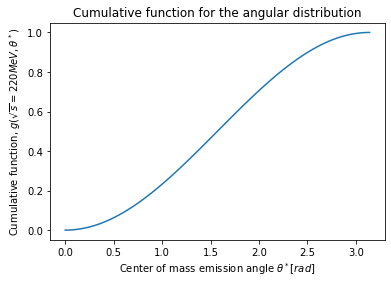

In [3]:
#function computing the cumulative density function of the angle distribution
def g(s, x): #x stands for theta star
    return s**2*3./8.*((1+4*(m_e**2+m_muon**2)/s)*(1-np.cos(x))+(1-4*m_e**2/s)*(1-4*m_muon**2/s)*(1-np.cos(x)**3)/3)/((2*m_e**2+s)*(2*m_muon**2+s))

#plotting g(x)
plt.title("Cumulative function for the angular distribution")
plt.xlabel(r'Center of mass emission angle $\theta^*[rad]$' )
plt.ylabel(r'Cumulative function, $g(\sqrt{s} = 220 MeV, \theta^*)$' )
plt.plot(x,g(s,x))
plt.show()

## Boosting muons four-momenta in the laboratory frame
We can now observe that the norm of the momentum of the outgoing muon can be written as follows:
$$ \lvert \vec p^{\,*}_\mu \rvert = \sqrt {\frac{s}{4}-m_\mu^2} $$
The momentum components' distributions can be simply derived knowing the center of mass energy - $\sqrt s$ - and the emission angles in the CoM - $ \theta^* $ and $ \phi^* $. 

$$ p^*_\mu = \lvert \vec p^{\,*}_\mu \rvert ( \frac {\sqrt s}{\lvert\vec p^{\,*}_\mu \rvert},  cos\theta^*, sin\theta^* cos\phi^*, sin\theta^* sin\phi^*) $$

3. Finally, the relation between the Lab angles and the COM ones has the usual formula: 
$$tan \theta_\mu  = \frac {sin\theta^*_\mu}{\gamma(cos\theta^*_\mu+\frac{\beta}{\beta^*_\mu})}   $$


If we are considering, without loss of generality, a boost along the x axis, the relations between the energy and momentum components are the following:  
$$ E_1 = \gamma ( E^*+\beta p^*_x) \,\,\,\,\,\, p_{1,x} = \gamma(\beta E^*+p^*_x ) $$

$$ E_2 = \gamma ( E^*-\beta p^{\,*}_x) \,\,\,\,\,\, p_{2,x} = \gamma(\beta E^*-p^{\,\,\,\,*}_x ) $$
The relation $$\vec p^*=\vec p_1^*=-\vec p_2^*$$ turns out, setting $$\theta_1^*=\theta^*, \,\,\,\,\,\, \phi_1^*=\phi^* $$ in the following relation between the angles of the two emerging muons: $$\theta_2^*=\pi+\theta^*, \,\,\,\,\,\,  \phi_2^*=\phi^*$$

4) To find out the inverse cumulative distribution function we define a uniform U(0,1) distribution and by interpolating the cumulative density function we extrapolate the angular value from the fitted function

4) In order to sample the angles accordingly to the angle distribution, we use the inverse CDF method. 
So we define a uniform distribution for $\theta ^* \in [0,\pi]$ and we interpolate with three different methods available in the scipy library the $g(s, \theta^*)$ function - the ordinate is represented by $g(s, \theta^*)$, the abscissa by $\theta^*$.

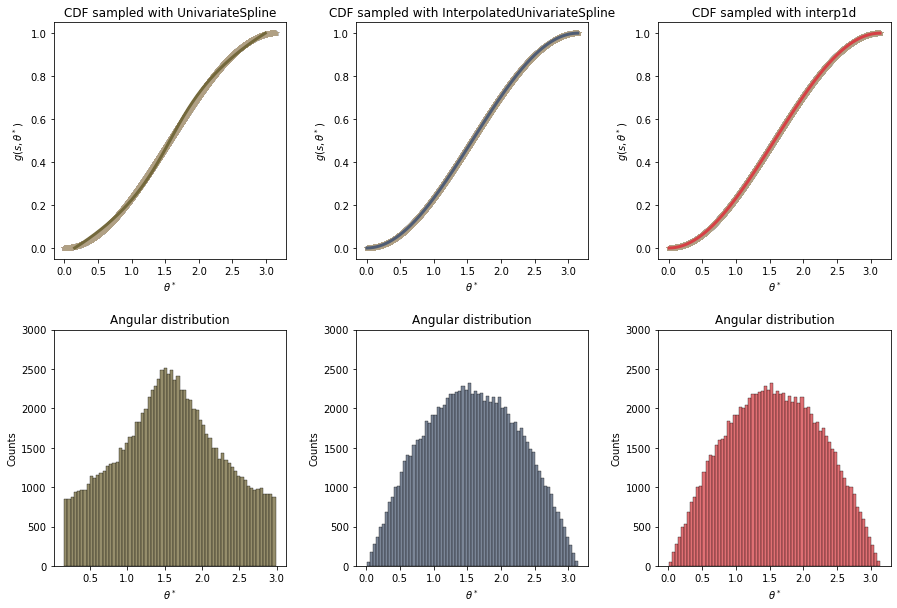

In [4]:
fig, ax = plt.subplots(2,3, figsize = (15,10))

N = 10**5

#angles on which we sample the inverse CDF
theta_star = np.linspace(0, np.pi, N)

#three version of inverse CDF sampling
inv_cdf1 = UnivariateSpline(g(s,theta_star),theta_star, ext=0)
inv_cdf2 = InterpolatedUnivariateSpline(g(s,theta_star),theta_star, ext=0)
inv_cdf3 = interp1d(g(s, theta_star), theta_star)

#same plot on each ax of the points
for i in range(3):
    ax[0][i].plot(theta_star,
               g(s,theta_star),
               '*',
               alpha = 0.005,
               color = '#B0A084',
               label = 'Samples'
              )
    ax[1][i].set_title('Angular distribution')
    
random_num = np.random.rand(N)
num_sorted = np.sort(random_num)

ax[0][0].set_title('CDF sampled with UnivariateSpline')
ax[0][0].plot(inv_cdf1(num_sorted),
           num_sorted,
           color = '#73683B',
           label = 'inv_CDF',
           linewidth = 3

          )

ax[0][1].set_title('CDF sampled with InterpolatedUnivariateSpline')
ax[0][1].plot(inv_cdf2(num_sorted),
           num_sorted,
           color = '#4F5D75',
           label = 'inv_CDF', 
           linewidth = 3
          )

ax[0][2].set_title('CDF sampled with interp1d')
ax[0][2].plot(inv_cdf3(num_sorted),
           num_sorted,
           color = '#D64045',
           label = 'inv_CDF', 
           linewidth = 3
          )

sns.histplot(inv_cdf1(num_sorted), ax = ax[1][0], color = '#73683B' )
sns.histplot(inv_cdf2(num_sorted), ax = ax[1][1], color = '#4F5D75',)
sns.histplot(inv_cdf3(num_sorted), ax = ax[1][2], color = '#D64045')

ax[1][0].set_ylim(0,3000)
ax[1][1].set_ylim(0,3000)
ax[1][2].set_ylim(0,3000)

for i in ax[0]:
        i.set_ylabel(r"$g(s, \theta^*)$")
        i.set_xlabel(r"$\theta^*$")
        
for j in ax[1]:
    j.set_ylabel(r"Counts")
    j.set_xlabel(r"$\theta^*$")


plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.3,
                    hspace=0.3
                   )

plt.show()

It can be noticed how different interpolating function lead to different distribution. 

In particular the 'Interpolate Spline' method is not able to fit the extremes providing a wrong angular distribution.

From now on, we will use interp1d as fitting method.

In [5]:
def mom_mu_cm(m_muon, s, t, p):
    #CoM momentum using cartesian components 
    p_norm = np.sqrt(s/4-m_muon**2)
    p_x_cm = p_norm * np.cos(t)
    p_y_cm = p_norm * np.sin(t)*np.cos(p)
    p_z_cm = p_norm * np.sin(t)*np.sin(p)
    return p_x_cm, p_y_cm, p_z_cm

def e_pos_lab(s, m_e):
    #positron energy in the laboratory frame
    return s/(2*m_e)-m_e


def p_pos_lab(s, m_e):
    #positron momentum in the laboratory frame
    e_pos = e_pos_lab(s, m_e)
    return np.sqrt(e_pos**2-m_e**2)

def beta(s, m_e):
    #lorentz beta function
    e_pos = e_pos_lab(s, m_e)
    p_pos = p_pos_lab(s, m_e)
    return p_pos / (e_pos + m_e)
    
def gamma(s, m_e):
    #lorentz gamma function    
    return 1./np.sqrt(1-beta(s, m_e)**2)

def Ecm(s):
    #CoM energy
    return np.sqrt(s)/2.

def boost(s, t, p, m_e, m_muon):
    '''boosting the muon-four momentum to the laboratory frame'''
    e_cm = Ecm(s)
    b = beta(s, m_e)
    g = gamma(s, m_e)
    px_cm, py_cm, pz_cm = mom_mu_cm(m_muon, s, t, p) #py pz does not change 
    px = g * (b * e_cm + px_cm) #boost px
    e = g * (e_cm + b * px_cm) #boost energy
    return px, py_cm, pz_cm


def mc_sampling(s, m_e, m_mu, N):
    '''montecarlo sampling to get theta^* distribution with inverse cdf method'''
    prob = np.random.rand(N)
    theta = inv_cdf3(prob)
    phi = np.random.uniform(0, 2*np.pi, N)
    muon_1 = boost(s, theta, phi, m_e, m_muon) 
    muon_2 = boost(s, np.pi+theta, phi, m_e, m_muon)
    return np.asarray(muon_1 + muon_2)


def mc_df_sampling(df, m_e, m_muon):
    #redefining sampling function in order to use dataframe and multiple number of energy values
    phi = np.random.uniform(0, 2*np.pi, df.shape[0])
    muon_1 = boost(np.asarray(df.energies), np.asarray(df.angles), phi, m_e, m_muon)
    muon_2 = boost(np.asarray(df.energies), np.asarray(df.angles+np.pi), phi, m_e, m_muon)
    return np.asarray(muon_1 + muon_2)

In [6]:
N = 10**6 #generating 10^6 events

events = mc_sampling(220**2, m_e, m_muon, N)
df_monochromatic = pd.DataFrame(events.T, columns = [  
                               '$px_{\mu_1}$',
                               '$py_{\mu_1}$',
                               '$pz_{\mu_1}$',
                               '$px_{\mu_2}$',
                               '$py_{\mu_2}$',
                               '$pz_{\mu_2}$'
                              ]
                )
df_monochromatic.to_csv('Events.csv')

In [7]:
df_monochromatic

,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,27413.532926,24.318443,-6.627569,19944.174714,-24.318443,6.627569
1,27046.287350,20.410877,-16.582920,20311.420291,-20.410877,16.582920
2,20123.855342,3.156629,25.565857,27233.852299,-3.156629,-25.565857
3,28282.959142,5.888772,-21.075542,19074.748499,-5.888772,21.075542
4,27601.176448,-13.978531,-20.221422,19756.531193,13.978531,20.221422
...,...,...,...,...,...,...
999995,27023.256790,-22.901232,-13.056282,20334.450850,22.901232,13.056282
999996,22587.941307,-29.936152,-3.801602,24769.766333,29.936152,3.801602
999997,19013.072546,-4.378231,21.150631,28344.635095,4.378231,-21.150631
999998,28613.491409,-9.474367,17.917957,18744.216232,9.474367,-17.917957


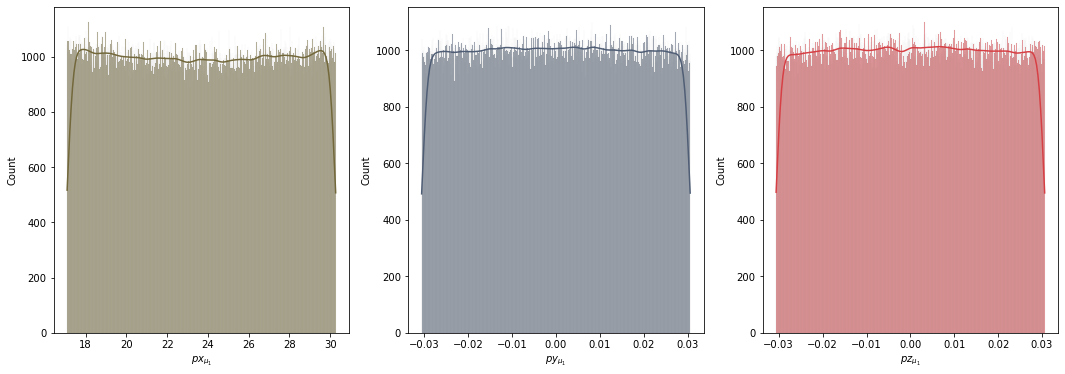

In [8]:
#plotting momentum components distribution in the LAB frame
fig, ax = plt.subplots(1,3, figsize = (18,6))



#px
sns.histplot(df_monochromatic['$px_{\mu_1}$']/1000,
             ax = ax[0],
             bins = int(np.sqrt(N)),
             kde = True,
             color = '#73683B'
            )
#py
sns.histplot(df_monochromatic['$py_{\mu_1}$']/1000,
             ax = ax[1],
             bins = int(np.sqrt(N)),
             kde = True,
             color = '#4F5D75'
            )
#pz
sns.histplot(df_monochromatic['$pz_{\mu_1}$']/1000,
             ax = ax[2],
             bins = int(np.sqrt(N)),
             kde = True,
             color = '#D64045'
            )

plt.show()

$p_y$ and $p_z$ components distributions are, as expected, uniform, equal and centered in zero. On the other hand, the $p_x$ distribution displays a negative concavity and peaks at the interval extremes.

# Montecarlo with real beam

    
7. Repeat what done so far simulating now the actual transverse shape and energy spread of the beam: for the former assume a flat distribution in a circle of radius $r=1$ cm and for the latter a gaussian distribution centered at the nominal beam energy and a width of $0.5$ GeV;


To get a simulation for the real beam we must add the information on how colliding particle energy and position distributes within the chosen set. For $s$ we assume a Gaussian with mean in 48.4 GeV and variance 0.5 GeV, where the beam energy is obtained as $\frac{s}{2 m_e}$. 

As the usingInvCDF method is not feasible due to too large computation time, we decide to exploit the accept-reject method in order to get a computationally reasonable task.


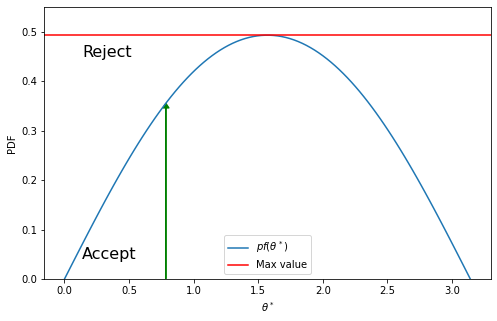

In [9]:
#Showing the accept-reject method main idea
fig, ax = plt.subplots(1, 1, figsize=(8,5))

thetas = np.linspace(0,np.pi,100)
ax.plot(thetas, pf(220**2,thetas), label=r'$pf(\theta^*)$')
ax.axhline(pf(220**2, np.pi/2), color='red', label='Max value')
ax.set_xlabel(r'$\theta^*$')
ax.set_ylabel(r'PDF')
ax.set_ylim([0,0.55])

plt.arrow(np.pi/4,0,0,pf(220**2,np.pi/4)-0.01, linewidth=1,
         head_width=0.05, head_length=0.01, fc='g', ec='g')

plt.text(np.pi/4-.65, 0.45, 'Reject', fontsize=16)
plt.text(np.pi/4-.65, 0.04, 'Accept', fontsize=16)
ax.legend(loc = 'best')

plt.show()

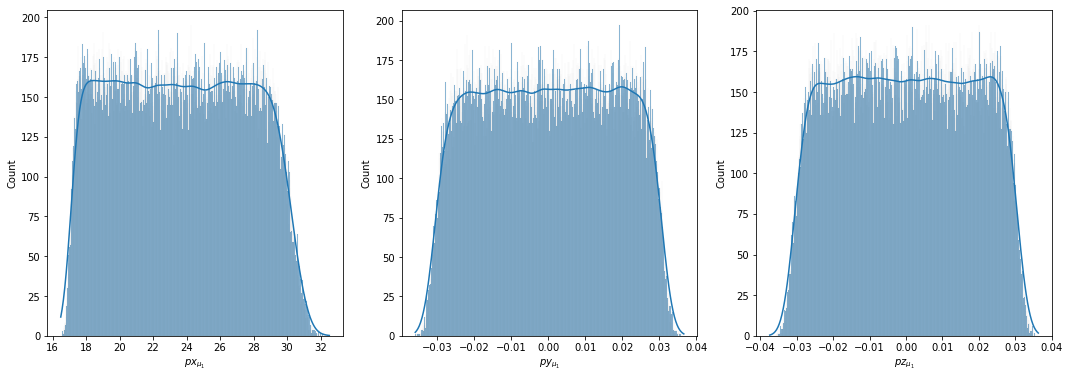

In [10]:
#generating energies in CoM (s=220**2 )
energies_gauss = np.random.normal(48400 , 500, 200294) 
#48400: s=220**2=48400
#500: std_dev of the gaussian distribution
#200294: Number of generated events

#we are sufficiently (>3 sigma) far from threshold. Pair production threshold is ok

#accept and reject method for angular distribution generation
pts = np.random.uniform( 0, np.pi, len(energies_gauss))
check = np.random.uniform( 0, pf(energies_gauss,np.pi/2), len(energies_gauss) )

df_energies_real_beam = pd.DataFrame(pd.Series(energies_gauss), columns = ['energies'])
df_energies_real_beam["angles"] =  pts
df_energies_real_beam["check"]  = check
df_energies_real_beam["label"]  = df_energies_real_beam.angles[df_energies_real_beam.check < pf(df_energies_real_beam.energies, df_energies_real_beam.angles)]
df_energies_real_beam = df_energies_real_beam.dropna()
df_energies_real_beam = df_energies_real_beam.iloc[:N] #Taking only the first N values


events = mc_df_sampling(df_energies_real_beam, m_e, m_muon)

df = pd.DataFrame(events.T, columns = [
                              '$px_{\mu_1}$',
                              '$py_{\mu_1}$',
                              '$pz_{\mu_1}$',
                              '$px_{\mu_2}$',
                              '$py_{\mu_2}$',
                              '$pz_{\mu_2}$'
                             ]
               )

#plotting momentum components
fig, ax = plt.subplots(1,3, figsize = (18,6))
sns.histplot(df['$px_{\mu_1}$']/1000, ax = ax[0], bins = int(np.sqrt(N)), kde=True)
sns.histplot(df['$py_{\mu_1}$']/1000, ax = ax[1], bins = int(np.sqrt(N)), kde=True)
sns.histplot(df['$pz_{\mu_1}$']/1000, ax = ax[2], bins = int(np.sqrt(N)), kde=True)
plt.show()

# Real beam 2: Spatial Distribution

Since the total and differential cross sections do not depend on the position, the only difference in the simulation regards the collision point. We proceed defining the new distribution and showing the new collision points. These can be simply generated using a uniform distribution over the axes y and z by selecting the points satisfying r < 1.

In [11]:
pts = np.random.uniform(-1, 1, size = (2*10**5, 2)) #point generation
acc = pts[np.sum(np.square(pts), axis=1) < 1] #accepted points
acc = acc[:10**5] #array of 10**5 valid points

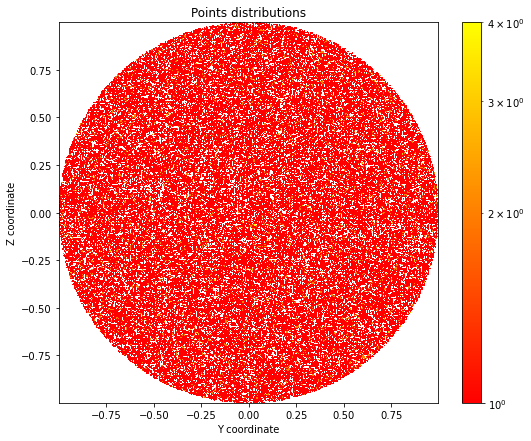

In [37]:
fig,ax = plt.subplots(1,1,figsize=(8.5,7))
h=ax.hist2d(acc[:,0], acc[:,1], bins=1000, cmap='autumn', norm=clr.LogNorm())
fig.colorbar(h[3], ax=ax)

ax.set_xlabel('Y coordinate')
ax.set_ylabel('Z coordinate')
ax.set_title("Points distributions")
plt.show()

## Berillium target statistics

In order to compute the scaling factor that retrieves the statistics for a one week data gathering, we compute the number of pairs produced for positron bunch on target $n(\mu^+ \mu^-)$ that is given by:
$$n(\mu^+ \mu^-)=n^+ \rho^- l \sigma(\mu^+ \mu^-)$$
where $n^+$ is the number of positrons in the bunch, $\rho^-$ is the electron density in the medium, $l$ is the target thickness and  $\sigma(\mu^+ \mu^-)$ is the muon pairs production cross-section.
Then, expressing it as a function of the impinging positrons rate $f^+$ it holds:
$$f(\mu^+ \mu^-)=f^+ \rho^- l \sigma(\mu^+ \mu^-)$$

It is possible to express $\rho^-$ as:
$$\rho^-=N_A \frac{\rho_{Be}Z}{M_t}$$
in which $N_A$ is the Avogadro number, $\rho_{Be}$ is the Beryllium density, Z is its atomic number and $M_t$ its molar mass.

Then the rescaling factor is given by W=$f(\mu^+ \mu^-) \Delta T$, where $\Delta T$ is the number of seconds in a week



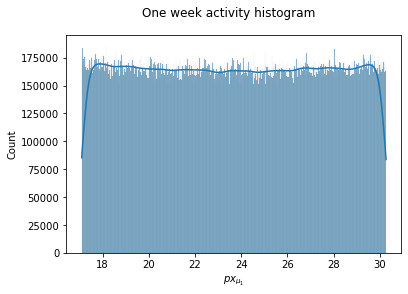

In [13]:
freq = 10**6
rhoBe = 1.848 #g/cm^3
N_a = 6.022*10**23 #Avogadro's number
Z = 4
M = 9.012 #u
l = 6 #cm
rho_elec = N_a * (rhoBe*Z) / (M) #
fmu = freq * rho_elec * l * sigma(230**2) * 1e-24 *38937
deltaT = 60 * 60 * 24 * 7
fweek = fmu * deltaT 

weights = np.full(int((N)), fweek/N)
df_monochromatic['weights']=weights

sns.histplot(x=df_monochromatic['$px_{\mu_1}$']/1000, 
             weights= df_monochromatic['weights'], 
             bins = int(np.sqrt(N)), 
             kde=True
             
            )
plt.suptitle('One week activity histogram')
plt.show()


## Longitudinal energy loss

In order to have threshold production of a muon pair, $\sqrt {s}$ should be slightly grater than the sum of the mass of two muons
$$\sqrt {s} > 2m_\mu \implies s > 4m_\mu^2 $$ 
So, rewriting the invariant quantity $s$ in the laboratory frame while taking into account that the electron is at rest we obtain
$$ s = E_{e_+}^2 + E_{e_-}^2+2E_{e_+}E_{e_-}-p_{e_+}^2 = E_{e_+}^2 + m_{e_-}^2+2E_{e_+}m_{e_-}-p_{e_+}^2$$
Joining the two conditions:
$$2E_{e_+}m_{e_-}>4m_{\mu}^2-2m_{e_-}^2$$
And finally the condition on the energy of the positron:
$$E_{e_+}>\frac{4m_{\mu}^2-2m_{e_-}^2}{2m_{e_{-}}}$$
But:
$$E_{e_{+}}=E_0e^{-\frac{x}{\chi_0}}$$
where $\chi_0$ is the radiation length of the Berylium: $\chi_0=35.28$ cm (from PDG). In order to have the condition satisfied along the whole length of the target we impose it at the end of it ($x_{max} =3$ cm). In the end, to find the $E_0$ that satisfies the condition we explicit for $E_0$ obtaining:
$$E_0>\left(\frac{4m_{\mu}^2-2m_{e_-}^2}{2m_{e_{-}}}\right)e^{\frac{x_{max}}{\chi_0}}\approx47.6 \, \mathrm{ GeV}$$ 

In [14]:
rad_length = 35.28 #cm (radiation length of Berylium taken from PDG)
z_max = 3 #cm

result= ((4*m_muon**2-2*m_e**2)/(2*m_e))*np.exp(z_max/rad_length)
print (result, 'MeV')

47571.03165490111 MeV


## Monochromatic analysis

We now take into account the energy loss along the target lenght. 
This leads to a variable pair-production probability depending on the cross-section value at that energy, that now is a function of position x. 
We then generate x-coordinates spread and retrieve the $\theta^*$ distribution, both through an accept-reject method. 

In [15]:
#s depending on x-coordinate (z)
def s_berms(z, E0):
    return 2 * m_e**2 + 2* E0 * np.exp(-z/rad_length) * m_e

#correspondent cross-section
def sigma_berms(z, E0):
    return sigma(s_berms(z, E0))


In [16]:
#accept-reject: energies
pts = np.random.uniform( 0, 3, 3*10**5)
check = np.random.uniform( 0, sigma_berms(0, result), 3*10**5 )
energies_berms = s_berms(pts[check < sigma_berms(pts,result)], result)

#checking for threshold condition
energies_berms = energies_berms[energies_berms > 4 * m_muon**2]

In [17]:
#accept-reject: angles
angles = np.random.uniform( 0, np.pi, len(energies_berms))
ang_check = np.random.uniform( 0, pf(energies_berms,np.pi/2), len(energies_berms) )

pd_df = pd.DataFrame(pd.Series(energies_berms), columns = ['energies'])
pd_df["angles"] =  angles
pd_df["check"]  = ang_check
pd_df["label"]  = pd_df.angles[pd_df.check < pf(pd_df.energies, pd_df.angles)]
pd_df = pd_df.dropna()

pd_df = pd_df.iloc[:N]

events = mc_df_sampling(pd_df, m_e, m_muon)

#momentum coordinates distribution
events = events.T
df = pd.DataFrame(events, columns = [
                              '$px_{\mu_1}$',
                              '$py_{\mu_1}$',
                              '$pz_{\mu_1}$',
                              '$px_{\mu_2}$',
                              '$py_{\mu_2}$',
                              '$pz_{\mu_2}$'
                             ]
               )

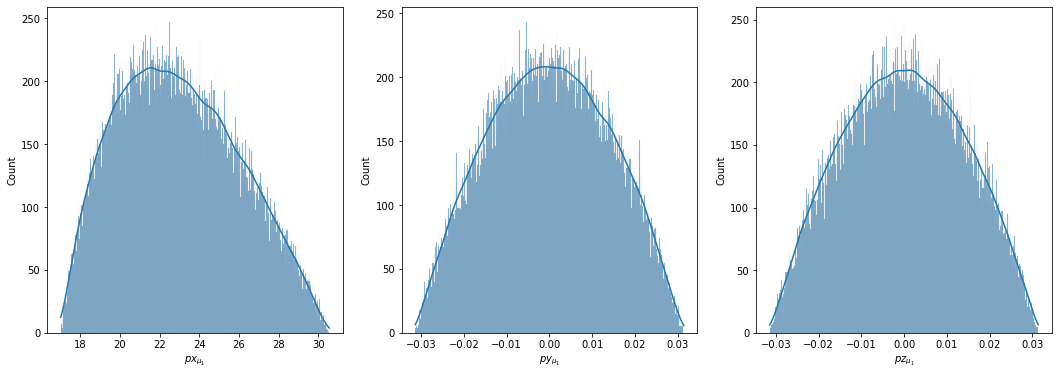

In [18]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
sns.histplot(df['$px_{\mu_1}$']/1000, ax = ax[0], bins = int(np.sqrt(N)), kde = True)
sns.histplot(df['$py_{\mu_1}$']/1000, ax = ax[1], bins = int(np.sqrt(N)), kde = True)
sns.histplot(df['$pz_{\mu_1}$']/1000, ax = ax[2], bins = int(np.sqrt(N)), kde = True)
plt.show()


## Non monochromatic analysis
Now, we have to take into account that the impinging beam energy follows a Gaussian distribution. Then for each starting energy, the beam will have a different cross-section value and maximum pair-production distance. 
In our analysis this leads to different pair-production energy distribution.

In [19]:
#max distance to have pair-production for that impinging energy
def max_d(E0, m_e, m_muon, rad_length):
    return np.log(E0/((4*m_muon**2-2*m_e**2)/(2*m_e)))*rad_length

In [20]:
#from CoM to lab
energies_gauss_brems = energies_gauss / (2 * m_e)

In [21]:
#accept-reject method to get pair-production energies
pts = np.random.uniform( 0, max_d(energies_gauss_brems,m_e,m_muon, rad_length), len(energies_gauss_brems))
check = np.random.uniform( 0, sigma_berms(0, energies_gauss_brems), len(energies_gauss_brems) )
pd_df_brems = pd.DataFrame(pd.Series(energies_gauss_brems), columns = ['energies'])
pd_df_brems["pts"] =  pts
pd_df_brems["check"]  = check
pd_df_brems["label"]  = pd_df_brems.pts[pd_df_brems.check < sigma_berms(pd_df_brems.pts, pd_df_brems.energies)]
pd_df_brems = pd_df_brems.dropna()
energies_berms = s_berms(pd_df_brems.pts,pd_df_brems.energies)

energies_berms = energies_berms[energies_berms > 4 * m_muon**2]

In [22]:
#accept-reject: angle distribution
angles = np.random.uniform( 0, np.pi, len(energies_berms))
ang_check = np.random.uniform( 0, pf(energies_berms,np.pi/2), len(energies_berms) )

pd_df = pd.DataFrame(pd.Series(energies_berms), columns = ['energies'])
pd_df["angles"] =  angles
pd_df["check"]  = ang_check
pd_df["label"]  = pd_df.angles[pd_df.check < pf(pd_df.energies, pd_df.angles)]
pd_df = pd_df.dropna()

pd_df = pd_df.iloc[:N]

events = mc_df_sampling(pd_df, m_e, m_muon)

events = events.T
df = pd.DataFrame(events, columns = [
                              '$px_{\mu_1}$',
                              '$py_{\mu_1}$',
                              '$pz_{\mu_1}$',
                              '$px_{\mu_2}$',
                              '$py_{\mu_2}$',
                              '$pz_{\mu_2}$'
                             ]
               )

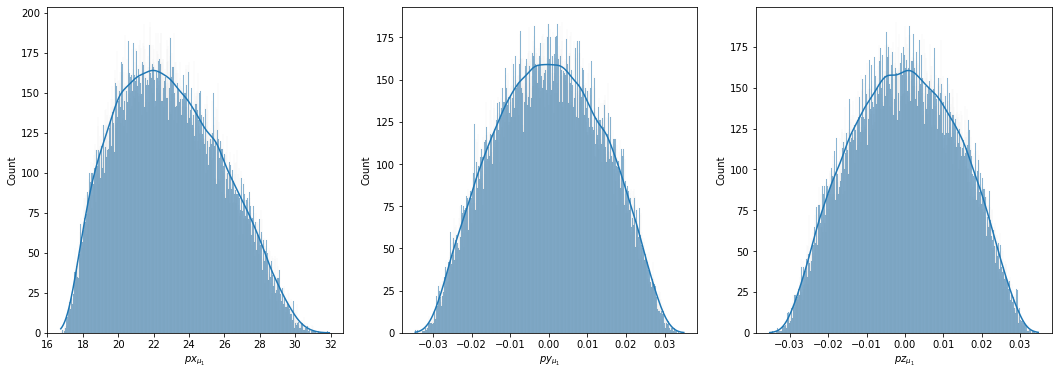

In [23]:
fig, ax = plt.subplots(1,3, figsize = (18,6))
sns.histplot(df['$px_{\mu_1}$']/1000, ax = ax[0], bins = int(np.sqrt(N)), kde = True)
sns.histplot(df['$py_{\mu_1}$']/1000, ax = ax[1], bins = int(np.sqrt(N)), kde = True)
sns.histplot(df['$pz_{\mu_1}$']/1000, ax = ax[2], bins = int(np.sqrt(N)), kde = True)
plt.show()


#### Part 2: use the synthetic dataset to design an experiment

Assume a $2$ meter long, $1.7$ Tesla dipole magnet is placed after the target. Assume a number of tracking detectors can be placed before the target, after the target before the magnet (one line) and after the magnet (two lines, one for positive the other for negative muons); those could be made of silicon pixels, with a single-hit resolution varying from 50 to 200 ${\rm \mu m}$.  
Try to address the following items keeping in mind that money matters (i.e. you cannot buy an infinite number of detectors and the smaller the single-hit resolution the higher the cost) and that the layout of the experiment has to be as compact as possible (say whithin 20 m).

1. Define the sizes of the various detectors, such that all the particles traverse them (i.e. $100\%$ detector acceptance); 
2. have each event of the synthetich dataset "interacting" with the detectors, i.e. generate a dataset with the hits (properly smeared due to detector resolutions) left by particles crosssing each detector. That should correspond to the actual measurments gathered by the experiment;
3. add some random noise to such measurements (e.g. for each detector accordingly to poisson statistic of mean about 1);
4. develop an algorithm to track the particles, both the incoming positrons and the outgoing muons.
5. keep in consideration the fact that the two muons emerge synchronously from the target: how small the pitch (the distance between individual pixels) have to be of the detectors prior to the magnet? If that is too small, adjust the tracking algorithm accordingly (i.e. the reconstruct muon tracks could share hits in those detectors) 
6. compute the resolution of the muon momenta and of the $\sqrt(s)$;
7. (optional, a though one..) correct the muon trajectories for the transverse position of the hard scattering on the target section. Actually the incoming positrons are both dispersed in space (the flat distribution with  $r=1$ cm) and divergent; one would need to correct for that too.

### References

* [LEMMA](https://arxiv.org/pdf/1509.04454.pdf) paper. The original paper describing the positron-induced low emittance muon source, ehere all the relevant kinematic features of the process have been studied
* [Babayaga](https://www2.pv.infn.it/~hepcomplex/babayaga.html) event generator. You may want to install and run it as a comparison for your results.
* [2018 Experiment](https://arxiv.org/pdf/1909.13716.pdf): the paper describing the (very poor..) results of the experiment carried out in summer 2018
* [2021 proposal](https://cds.cern.ch/record/2712394?ln=en): the proposal for the experiment in 2021


### Contact

* Marco Zanetti <marco.zanetti@unipd.it> (very poor..) 
* Camilla Curatolo <camilla.curatolo@pd.infn.it>
* Jacopo Pazzini <jacopo.pazzini@unipd.it>
* Alberto Zucchetta <alberto.zucchetta@pd.infn.it>